In [1]:
import os
import copy
from __future__ import print_function

#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statistics 
import pyreadr
import scipy.io as sio
from itertools import combinations
from sklearn.model_selection import train_test_split

#Probabilistic programs
#Probabilistic programs
#!pip install pymc==5.0.2
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
#import aesara.tensor as at
print('Running on PyMC v{}'.format(pm.__version__))


#Graphs
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
#from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
#from graphviz import Source, Digraph
#import dot2tex as d2t
#from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az
import colorsys

# Image processing stuff
#!pip install opencv-python
import cv2

#User-defined functions (in the same folder as the notebook)
import my_fun as mf

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.0.1


# Decision criterion

Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

# Signal detection theory


We ask a couple of people to detect several times if there is a tone/signal/voice from behind in a noisy environment. <br><br>
In the figure, Laurie says "yes" more times. Is Laurie more sensitive to the tone/signal/voice from behind than Chris?

<center><img src="img/9_CB/Goldstein1.png" width = "501" height = '500'></center>
Source: Goldestein, 1996, Sensation & Perception.

Laurie says yes more and it may generate more hits but also more false alarms.<br><br>

|              | Signal + Noise trial |    Noise Trial    |
|--------------|:--------------------:|:-----------------:|
| Yes response |          Hit         |    False alarm    |
| No response  |         Miss         | Correct rejection |

x-axis: internal activity strength (assumption: noise produces weaker activity)<br>
$d$: distance between noise and signal <br>
$d/2$: optimal decision criterion if signal and noise trials occur with equal probability <br>
$k$: decision criteria used by the person (e.g. if activity strength>$k$, say yes) <br>
$c$: bias i.e. criteria used ($k$) minus optimal criteria ($d/2$)<br>
$\theta^h$: hit probability <br>
$\theta^f$: false alarm probability <br>

<br><br>

<center><img src="img/9_CB/Lee_Wagenmakers1.svg" width = "501" height = '500'></center>
Source: Lee & Wagenmakers (2013)

# Exercise

* In the previous figure, shade the area that would correspond to "Miss" and which would correspond to "Correct Rejection".

Going back to Laurie and Chris, there are at least two hypotheses for this data:
* Laurie y Chris difieren en d (sensibilidad)
* Laurie y Chris difieren en k (criterio)
<br><br>
<center><img src="img/9_CB/Goldstein1.png" width = "501" height = '500'></center>
Source: Goldestein, 1996, Sensation & Perception.

It does not only apply to perceptual phenomena. Any decision making will depend on the discriminability and thresholds that are set.

<center><img src="img/9_CB/Krajbich1.svg" width = "451" height = '450'></center>
Source: Krajbich, et al, 2015

Krajbich, et al, 2015, in fact find that once controlling for discriminability, the idea of thinking fast and slow (bars) disappears (scatter plots).

| Dictator Game | Intertemporal Discounting |
|:-------------:|:-------------------------:|
|      <center><img src="img/9_CB/Krajbich2.svg" width = "451" height = '450'></center>      |        <center><img src="img/9_CB/Krajbich3.svg" width = "451" height = '450'></center>       |


In a framework that integrates expected value and signal detection theory, the optimal criteria should consider expected value (Lynn, Wormwood, Barrett, & Quigley, 2015). Here, the decision to cycle or car depends on both the expected value of the transportation method and the probability of rain.
<br><br>

<center><img src="img/9_CB/Lynn1.jpg" width = "551" height = '550'></center>

Let see how to implement a simple signal detection theory (SDT) model in PyMC

$c_i:$ bias <br>
$d_i:$ distance between signal and noise distributions <br>
$\theta_i^f:$ false alarm <br>
$\theta_i^h:$ hit rate <br>
$h_i, \ f_i:$ Hits and false alarms observed, respectively <br>
$s_i, \ n_i:$ signal and noise trials, respectively <br><br>


<center><img src="img/9_CB/model_SDT.svg" width = "551" height = '550'></center>

In [2]:
## Based in https://github.com/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3
#  Load data
dataset = 1
if dataset == 1:  # Demo
    k = 3  # number of cases
    data = np.array([70, 50, 30, 50, 7, 5, 3, 5, 10, 0, 0, 10]).reshape(k, -1)
else:  # Lehrner et al. (1995) data
    k = 3  # number of cases
    data = np.array([148, 29, 32, 151, 150, 40, 30, 140, 150, 51, 40, 139]).reshape(
        k, -1
    )

# Number of ...
h = data[:, 0] #hits (each row is a subject)
f = data[:, 1] #false alarm
MI = data[:, 2] #miss
CR = data[:, 3] #correct rejection
s = h + MI #signal trials
n = f + CR #noise trials

In [3]:
def Phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    # Also it is the probit transform
    return 0.5 + 0.5 * pm.math.erf(x / pm.math.sqrt(2))

In [4]:
with pm.Model() as model1:
    #Priors
    di = pm.Normal("Discriminability", mu=0, tau=0.5, shape=k) #d
    ci = pm.Normal("Bias", mu=0, tau=2, shape=k) #c

    #Likelihood
    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))
    
    hi = pm.Binomial("hi", p=thetah, n=s, observed=h)
    fi = pm.Binomial("fi", p=thetaf, n=n, observed=f)
    
    #Sampling
    trace1 = pm.sample()
    #data = az.from_pymc3(trace=trace1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Discriminability, Bias]
c:\users\santiago diaz\appdata\local\programs\python\python39\lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


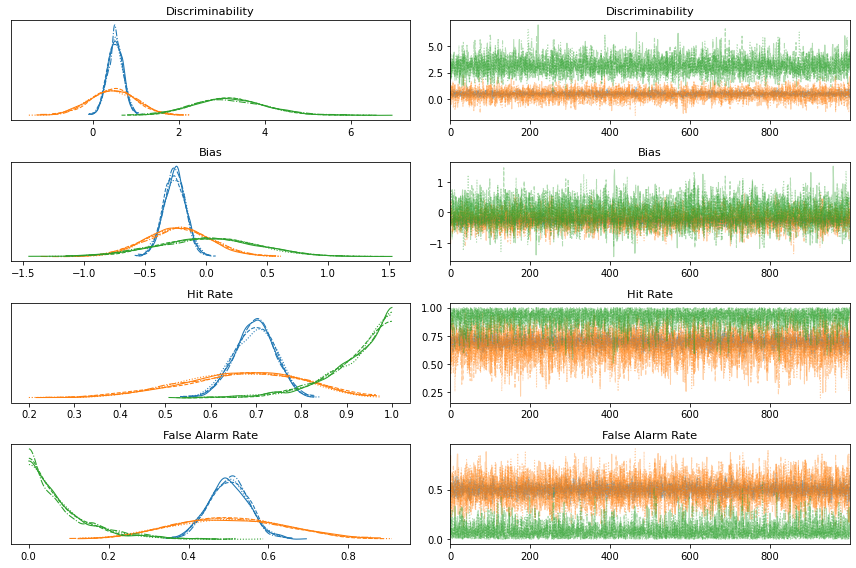

In [5]:
az.plot_trace(
    trace1, var_names=["Discriminability", "Bias", "Hit Rate", "False Alarm Rate"], compact=True
);
plt.tight_layout()

# Exercise

* What does it mean that the discriminability and bias priors are centered at zero? Do you think that the discriminability and bias priors are appropriate? Try other parameters for the normal prior or other functional forms and comment if you see (or not) changes.

* Analyse the following table with signal detection theory (SDT). Use the previous PyMC model. The table shows data from an experiment with three populations and their ability to recognize odors. Control: no COVID (n=18), Group 1: severe COVID (n=18), Group 2: mild COVID (n=19). The experiment was in three phases. First: memorize 10 smells. Second: wait 15 minutes. Third: out of 20 smells, recognize if they are new or old (10 were new, 10 old). The table has the aggregate sum per group.
     * What is the discriminability and bias of each group?
     * What conclusions do you draw?
     * Can you say something about individual differences in the same group?

|          |  Control |  Control | Group I  | Group I  | Group II | Group II |
|----------|:--------:|:--------:|----------|----------|----------|----------|
|          | Old odor | New odor | Old odor | New odor | Old odor | New odor |
| Old resp | 148      | 29       | 150      | 40       | 150      | 51       |
| New resp | 32       | 151      | 30       | 140      | 40       | 139      |

Now let's look at a hierarchical version of SDT

In hierarchical models we assume that the parameters, in this case discriminability and biases, vary between subjects, and that variation comes from a population distribution, in this case represented by the priors $\mu_c, \ \mu_d, \ \lambda_c, \ \ lambda_d$ <br><br>

<center><img src="img/9_CB/model_hSDT.svg" width = "551" height = '550'></center>

The data comes from an experiment by Heit & Rotello (2005) that tries to evaluate the conjecture that the difference between inductive reasoning (particular to general; Juan, Sofia, Heriberto, Karla, are mortal; all men are mortal) and deductive (general to particular; all men are mortal; Pepe is mortal) can be framed in signal detection theory.

Specifically, the hypothesis is that the deductive decision criterion is greater than the inductive one (Rips, 2001).

Characteristics of the experiment:
* 80 participants.
* 8 arguments
* Between-subject design
* Those in the inductive group (n=40) answered questions such as "how plausible?"
* Those in the deductive group (n=40) answered questions such as "is it necessarily true?"
* Hits, false alarms, miss, and correct rejections were counted.

The questions always started with: Assuming the sentences above the line are true... <br>
In the inductive condition the questions were of the type: how plausible? how convincing? <br>
In the deductive condition the questions were of the type: Does it necessarily imply? Can you be sure? <br><br>
<center><img src="img/9_CB/rips1.svg" width = "501" height = '500'></center>

<center><img src="img/9_CB/rips2.svg" width = "501" height = '500'></center>
Heit & Rotello (2005) 

In [6]:
std_d = pd.read_csv("data/9_CB/heit_rotello_std_d.csv") # deduction data
std_i = pd.read_csv("data/9_CB/heit_rotello_std_i.csv") # induction data

#Induction
h1  = np.array(std_i['V1']) #hits
f1  = np.array(std_i['V2']) #false alarm
MI1 = np.array(std_i['V3']) #miss
CR1 = np.array(std_i['V4']) #correct rejection
s1 = h1 + MI1 #signal trials
n1 = f1 + CR1 #noise trials

#Deduction
h2  = np.array(std_d['V1'])
f2  = np.array(std_d['V2'])
MI2 = np.array(std_d['V3'])
CR2 = np.array(std_d['V4'])
s2 = h2 + MI2
n2 = f2 + CR2

k = len(h1)

In [7]:
#Inductive model
with pm.Model() as model2i:
    #Priors
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)

    di = pm.Normal("di", mu=mud, tau=lambdad, shape=k)
    ci = pm.Normal("ci", mu=muc, tau=lambdac, shape=k)
    
    #Likelihood
    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s1, observed=h1)
    fi = pm.Binomial("fi", p=thetaf, n=n1, observed=f1)
    
    trace_i = pm.sample(target_accept=0.95)
    #data_i = az.from_pymc3(trace=trace_i)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mud, muc, lambdad, lambdac, di, ci]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


In [8]:
with pm.Model() as model2d:
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)

    di = pm.Normal("di", mu=mud, tau=lambdad, shape=k)
    ci = pm.Normal("ci", mu=muc, tau=lambdac, shape=k)

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s2, observed=h2)
    fi = pm.Binomial("fi", p=thetaf, n=n2, observed=f2)
    
    trace_d = pm.sample(target_accept=0.95)
    #data_d = az.from_pymc3(trace=trace_d)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mud, muc, lambdad, lambdac, di, ci]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [12]:
trace_d.posterior['muc'].shape

(4, 1000)

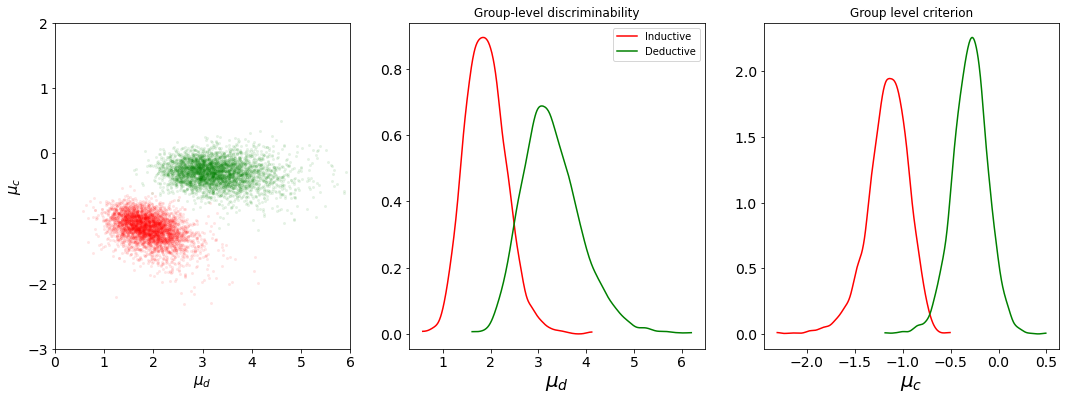

In [15]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
az.plot_pair(trace_i, var_names=["mud", "muc"], scatter_kwargs={"alpha": 0.1, "color": "red"}, 
                    figsize = (8,8), ax = ax[0])
az.plot_pair(trace_d, var_names=["mud", "muc"], scatter_kwargs={"alpha": 0.1, "color": "green"}, ax=ax[0])
ax[0].set_xlim((0, 6))
ax[0].set_ylim((-3, 2))
ax[0].set_xlabel(r"$\mu_d$")
ax[0].set_ylabel(r"$\mu_c$");
az.plot_dist(np.array(trace_i.posterior['mud']).flatten(), ax = ax[1], color = 'red', label = 'Inductive')
az.plot_dist(np.array(trace_d.posterior['mud']).flatten(), ax = ax[1], color = 'green', label = 'Deductive')
ax[1].set_xlabel(r"$\mu_d$", fontsize = 20);
ax[1].set_title('Group-level discriminability')
az.plot_dist(np.array(trace_i.posterior['muc']).flatten(), ax = ax[2], color = 'red')
az.plot_dist(np.array(trace_d.posterior['muc']).flatten(), ax = ax[2], color = 'green')
ax[2].set_xlabel(r"$\mu_c$", fontsize = 20);
ax[2].set_title('Group level criterion');

# Exercises

* Based on the posterior of the criterion, does it make sense to conjecture that human deduction is simply requiring stronger arguments?

* Based on the posterior of discriminability, how much does your answer change from the previous point? how important is it to the conjecture that the discriminability be equal?

# Appendix

In [ ]:
#Hierarchical Drift Diffusion Model (HDDM)
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Hierarchical Drift Diffusion Model (HDDM)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           mu_v -> v;\
           sigma_v -> v;\
           mu_a -> a;\
           sigma_a -> a;\
           mu_z -> z;\
           sigma_z -> z;\
           mu_ndt -> ndt;\
           sigma_ndt -> ndt;\
           v -> x;\
           a -> x;\
           z -> x;\
           ndt -> x;\
           sv -> x;\
           sz -> x;\
           sndt -> x;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$j subject$";\
               v;\
               a;\
               z;\
               ndt;\
               subgraph cluster1 {\
                   margin = 5; labeljust=l; lblstyle="font=\\small";\
                   style = rounded;\
                   label = "$i trial$";\
                   x;\
               }\
           }\
           /* nodes */\
           v [label = "$v_j$", shape = circle];\
           mu_v [label = "$mu_v$", shape = circle];\
           sigma_v [label = "$sig_v$", shape = circle];\
           a [label = "$a_j$", shape = circle];\
           mu_a [label = "$mu_a$", shape = circle];\
           sigma_a [label = "$sig_a$", shape = circle];\
           z [label = "$z_j$", shape = circle];\
           mu_z [label = "$mu_z$", shape = circle];\
           sigma_z [label = "$sig_z$", shape = circle];\
           ndt [label = "$ndt_j$", shape = circle];\
           mu_ndt [label = "$mu_{ndt}$", shape = circle];\
           sigma_ndt [label = "$sig_{ndt}$", shape = circle];\
           sv [label = "$s_v$", shape = circle];\
           sz [label = "$s_z$", shape = circle];\
           sndt [label = "$s_{ndt}$", shape = circle];\
           x [label = "$x_{ji}$", fillcolor = gray, style = filled, shape = square];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_HDDM.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#distributions:
# \mu_v \sim Normal(2,3)
# \sigma_v \sim Half \ Normal(0,2)
# \mu_a \sim Normal(1.5,0.75)
# \sigma_a \sim Half \ Normal(0,0.1)
# \mu_z \sim Normal(0.5,0.5)
# \sigma_z \sim Half \ Normal(0,0.05)
# \mu_{ndt} \sim Normal(0.4,0.2)
# \sigma_{ndt} \sim Half \ Normal(0,1)
# s_v \sim Half \ Normal(0,2)
# s_z \sim Beta(1,3)
# s_{ndt} \sim Half \ Normal(0,0.3)
# a_j \sim \Gamma(\mu_a, \sigma_a^2)
# v_j \sim Normal(\mu_v, \sigma_v^2)
# z_j \sim invlogit(Normal(\mu_z, \sigma_z^2))
# ndt_j \sim Normal(\mu_{ndt}, \sigma_{ndt}^2)
# x_{ji} \sim \frac{\pi}{a_j^2} e^{\left( -v_j a_j z_j - \frac{v_j^2x}{2} \right)} \times \sum_{k=1}^{\infty} k e^{\left(-\frac{k^2\pi^2x}{2a_j^2}\right)} sin(k \pi z_j)


#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{34pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}

In [ ]:
#Signal detection theory
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Signal Detection Theory (SDT)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           c -> theta_h;\
           c -> theta_f;\
           d -> theta_h;\
           d -> theta_f;\
           theta_f -> f;\
           theta_h -> h;\
           s -> h;\
           n -> f;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$i data sets$";\
               c;\
               d;\
               s;\
               n;\
               h;\
               f;\
               theta_f;\
               theta_h;\
           }\
           /* nodes */\
           c [label = "$c_i$", shape = circle];\
           d [label = "$d_i$", shape = circle];\
           s [label = "$s_i$", fillcolor = gray, style = filled, shape = square];\
           n [label = "$n_i$", fillcolor = gray, style = filled, shape = square];\
           h [label = "$h_i$", fillcolor = gray, style = filled, shape = square];\
           f [label = "$f_i$", fillcolor = gray, style = filled, shape = square];\
           theta_f [label = "$theta_i^f$", shape = circle, peripheries = 2];\
           theta_h [label = "$theta_i^h$", shape = circle, peripheries = 2];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_SDT.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#d_i \sim Normal(0, \frac{1}{2})
#c_i \sim Normal(0,2)
#\theta_i^h = \Phi(\frac{1}{2}d_i - c_i)
#\theta_i^f = \Phi(-\frac{1}{2}d_i - c_i)
#h_i \sim Binomial(\theta_i^h, s_i)
#f_i \sim Binomial(\theta_i^f, n_i)



In [ ]:
# Hierarchical signal detection theory
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Hierarchical Signal Detection Theory (SDT)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           lambda_c -> c;\
           mu_c -> c;\
           lambda_d -> d;\
           mu_d -> d;\
           c -> theta_h;\
           c -> theta_f;\
           d -> theta_h;\
           d -> theta_f;\
           theta_f -> f;\
           theta_h -> h;\
           s -> h;\
           n -> f;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$i people$";\
               c;\
               d;\
               s;\
               n;\
               h;\
               f;\
               theta_f;\
               theta_h;\
           }\
           /* nodes */\
           lambda_c [label = "$lam_c$", shape = circle];\
           lambda_d [label = "$lam_d$", shape = circle];\
           mu_c [label = "$mu_c$", shape = circle];\
           mu_d [label = "$mu_d$", shape = circle];\
           c [label = "$c_i$", shape = circle];\
           d [label = "$d_i$", shape = circle];\
           s [label = "$s_i$", fillcolor = gray, style = filled, shape = square];\
           n [label = "$n_i$", fillcolor = gray, style = filled, shape = square];\
           h [label = "$h_i$", fillcolor = gray, style = filled, shape = square];\
           f [label = "$f_i$", fillcolor = gray, style = filled, shape = square];\
           theta_f [label = "$theta_i^f$", shape = circle, peripheries = 2];\
           theta_h [label = "$theta_i^h$", shape = circle, peripheries = 2];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_hSDT.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#\mu_c, \ \mu_d \sim Normal(0,0.001)
#\lambda_c, \ \lambda_d \sim Normal(0.001,0.001)
#d_i \sim Normal(\mu_d, \lambda_d)
#c_i \sim Normal(\mu_c, \lambda_c)
#\theta_i^h = \Phi(\frac{1}{2}d_i - c_i)
#\theta_i^f = \Phi(-\frac{1}{2}d_i - c_i)
#h_i \sim Binomial(\theta_i^h, s_i)
#f_i \sim Binomial(\theta_i^f, n_i)